<!-- ## HRV-Plus-Ultra : Mediapipe Face Landmarking

Overview: try to take a sample on each 30 sec interval, the first attempt shows possible noise on the main signal. Denoising the signal should be performed with investigation along with butter filter.

### Performance Comparison (30 sec length)
- Process with RunningMode.Video : 2:37 
- Process with RunningMode.Image : 2:43

Drawing the Facelandmark point is kinda useless in here, the result withtout drawing the landmark is around `1:43`

Well, the differences is kinda thin. The video utilizes something called `Temporal Information` which I guess doesn't fit too for my case, but let's stick to the Video one -->

In [81]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy.signal as signal
import time

In [82]:
## Original Video
original_video = cv2.VideoCapture('../Samples/Original/vid_s53_T3.avi') # 35 Hz

## Ground Truth
ground_truth = pd.read_csv('../Samples/Original/bvp_s53_T3.csv', header=None).values.flatten() # 64 Hz

<!-- ---

## Resampling the Ground Truth to match with the Frame Video Frame Rate -->

In [83]:
## Downsampling the ground truth to match on 35.14 Hz

# Original ground truth sampling rate
original_rate = 64.0  # Hz

# Target sampling rate
target_rate = 35  # Hz

# Calculate the number of samples after resampling
num_samples = int(len(ground_truth) * (target_rate / original_rate))

# Resample the ground truth data
downsampled_ground_truth = signal.resample(ground_truth, num_samples)

# Create a new DataFrame for the downsampled data
downsampled_ground_truth_df = pd.DataFrame(downsampled_ground_truth, columns=['BVP'])

## Show the downsampled ground truth length
print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


Downsampled ground truth length: 6300


<!-- ---

## Using POS (Plate Orthogonal to Skin) for the RPPG Technique to Estimate Heart Rate

[Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf) -->

In [84]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

In [85]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image


In [86]:
## Create Facelandmarker Object
base_options = python.BaseOptions(model_asset_path="Models/face_landmarker.task")
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    running_mode = VisionRunningMode.VIDEO,
)
detector = vision.FaceLandmarker.create_from_options(options)

In [87]:
def get_cheek_rois(landmarks, image_shape):
    h, w, _ = image_shape
    left_cheek_indices = [111, 121, 50, 142]
    right_cheek_indices = [350, 340, 355, 280]

    left_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_cheek_indices]
    right_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_cheek_indices]

    left_cheek_rect = (
        min([pt[0] for pt in left_cheek_points]), min([pt[1] for pt in left_cheek_points]),
        max([pt[0] for pt in left_cheek_points]), max([pt[1] for pt in left_cheek_points])
    )
    print("Left Cheek Rect:", left_cheek_rect)
    right_cheek_rect = (
        min([pt[0] for pt in right_cheek_points]), min([pt[1] for pt in right_cheek_points]),
        max([pt[0] for pt in right_cheek_points]), max([pt[1] for pt in right_cheek_points])
    )
    print("Right Cheek Rect:", right_cheek_rect)

    return left_cheek_rect, right_cheek_rect


In [88]:
def extract_rgb_from_rect(rect, image):
    x_min, y_min, x_max, y_max = rect
    roi = image[y_min:y_max, x_min:x_max]
    return roi


<!-- ### Working on the Original Video First

Theoretical: Since working with the entire 180 seconds video is resource intensive, working with the smaller bits first should be work well. My Approach is on the 20 first seconds. -->

In [89]:
# Prepare variables for the RPPG method
# Lists to store RGB values
left_r_signal, left_g_signal, left_b_signal = [], [], []
right_r_signal, right_g_signal, right_b_signal = [], [], []
# Lists to store combined RGB values
combined_r_signal, combined_g_signal, combined_b_signal = [], [], []

fs = 35 
frame_index = 0
interval_duration = 30 # 30 seconds interval
frame_rate = original_video.get(cv2.CAP_PROP_FPS)   
buffer_size = int(fs * interval_duration) # 1050 Frame buffer
frame_buffer = []


In [90]:
"""
Our theoretical here, since the subject is moving along the video.
"""

## Main Loop 
try:
    f_count = 0
    f_total = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))

    while original_video.isOpened():
        print(f'Processing Frame {f_count}/{f_total}', end='\r')
        ret, frame = original_video.read()
        
        if not ret:
            break
        
        ### 3. Mendeteksi area wajah menggunakan mediapipe
        h, w, _ = frame.shape
        
        ### 3.1 Mengkonversi frame ke RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=frame_rgb
        )
        ### 3.2 Memproses frame menggunakan face_detection
        frame_timestamp_ms = int((frame_index / fs) * 1000)

        result = detector.detect_for_video(mp_image, frame_timestamp_ms)

        if result.face_landmarks:
            for face_landmark in result.face_landmarks:
                # Get cheek ROIs
                left_cheek_rect, right_cheek_rect = get_cheek_rois(face_landmark, frame.shape)

                # Draw both cheek ROIs with rectangles
                cv2.rectangle(frame, (left_cheek_rect[0], left_cheek_rect[1]), (left_cheek_rect[2], left_cheek_rect[3]), (0, 255, 0), 2)
                cv2.rectangle(frame, (right_cheek_rect[0], right_cheek_rect[1]), (right_cheek_rect[2], right_cheek_rect[3]), (0, 255, 0), 2)

                # Extract the left and right cheek ROIs
                left_cheek_roi = extract_rgb_from_rect(left_cheek_rect, frame)
                right_cheek_roi = extract_rgb_from_rect(right_cheek_rect, frame)

                # Calculate mean pixel values for the RGB channels
                left_cheek_rgb = cv2.mean(left_cheek_roi)[:3]
                right_cheek_rgb = cv2.mean(right_cheek_roi)[:3]

                # Append the RGB values to the respective lists
                left_r_signal.append(left_cheek_rgb[0])
                left_g_signal.append(left_cheek_rgb[1])
                left_b_signal.append(left_cheek_rgb[2])

                right_r_signal.append(right_cheek_rgb[0])
                right_g_signal.append(right_cheek_rgb[1])
                right_b_signal.append(right_cheek_rgb[2])

                # Combine and average the RGB values from both cheeks
                combined_r = (left_cheek_rgb[0] + right_cheek_rgb[0]) / 2
                combined_g = (left_cheek_rgb[1] + right_cheek_rgb[1]) / 2
                combined_b = (left_cheek_rgb[2] + right_cheek_rgb[2]) / 2

                # Append the combined RGB values to the respective lists
                combined_r_signal.append(combined_r)
                combined_g_signal.append(combined_g)
                combined_b_signal.append(combined_b)


                # # Extract the mean RGB values from the left and right cheek ROIs        
                # left_cheek_rgb = extract_rgb_from_rect(left_cheek_rect, frame)
                # right_cheek_rgb = extract_rgb_from_rect(right_cheek_rect, frame)

                # # Append the RGB values to the respective lists
                # left_r_signal.append(np.mean(left_cheek_rgb[0]))
                # left_g_signal.append(np.mean(left_cheek_rgb[1]))
                # left_b_signal.append(np.mean(left_cheek_rgb[2]))

                # right_r_signal.append(np.mean(right_cheek_rgb[0]))
                # right_g_signal.append(np.mean(right_cheek_rgb[1]))
                # right_b_signal.append(np.mean(right_cheek_rgb[2]))

        # if results.detections: # If there are faces detected
        #     for detection in results.detections: # Loop through all the detected faces
        #         ### 3.3 Mendapatkan bounding box dari wajah
        #         bbox = detection.location_data.relative_bounding_box
        #         ### 3.4 Mendapatkan lebar dan tinggi frame
        #         h, w, _ = frame.shape
        #         ### 3.5 Mengkonversi bounding box ke koordinat piksel
        #         x, y = int(bbox.xmin * w), int(bbox.ymin * h)
        #         ### 3.6 Mengkonversi lebar dan tinggi bounding box ke koordinat piksel
        #         width, height = int(bbox.width * w), int(bbox.height * h)
                
        #         ### 3.8 Menggambar bounding box pada frame
                
        #         ### 4 Mendapatkan nilai rata-rata piksel dari ROI dan menambahkannya ke signal
        #         # Define forehead ROI
        #         forehead_x = x + width // 4  # Start slightly to the right of the left edge
        #         forehead_y = y // 2 + 55 # Start at the top of the bounding box
        #         forehead_width = width // 2  # Half the width of the bounding box
        #         forehead_height = height // 5  # Quarter the height of the bounding box
                
        #         # Extract the forehead ROI
        #         roi = frame[forehead_y:forehead_y+forehead_height, forehead_x:forehead_x+forehead_width]
                
        #         # Optional: Draw the forehead ROI on the frame for visualization
        #         cv2.rectangle(frame, 
        #                       (forehead_x, forehead_y), 
        #                       (forehead_x + forehead_width, forehead_y + forehead_height), 
        #                       (0, 255, 0), 2)

        #         # Calculate mean pixel values for the RGB channels
        #         r_signal.append(np.mean(roi[:, :, 0]))
        #         g_signal.append(np.mean(roi[:, :, 1]))
        #         b_signal.append(np.mean(roi[:, :, 2]))

        # annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), result)

        # Add frame to buffer
        frame_buffer.append(frame)
        f_count += 1
        frame_index += 1

        # # Check if buffer is full
        # if len(frame_buffer) >= buffer_size:
        #     # Process the buffered rPPG signals
        #     break

        ## Convert back to BGR
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    original_video.release()
    cv2.destroyAllWindows()

    ## Convert as an array for numpy==1.26
    # left_r_signal = np.asarray(left_r_signal, dtype="object")
    # left_g_signal = np.asarray(left_g_signal, dtype="object")
    # left_b_signal = np.asarray(left_b_signal, dtype="object")
    # right_b_signal = np.asarray(right_b_signal, dtype="object")
    # right_g_signal = np.asarray(right_g_signal, dtype="object")
    # right_r_signal = np.asarray(right_r_signal, dtype="object")
    
except Exception as e:
    original_video.release()
    cv2.destroyAllWindows()
    print(f"An error occurred: {e}")

Left Cheek Rect: (381, 384, 500, 443)
Right Cheek Rect: (599, 406, 677, 464)
Left Cheek Rect: (382, 384, 501, 442)
Right Cheek Rect: (599, 406, 677, 464)
Left Cheek Rect: (382, 383, 501, 441)
Right Cheek Rect: (599, 405, 677, 464)
Left Cheek Rect: (383, 382, 502, 441)
Right Cheek Rect: (600, 405, 677, 464)
Left Cheek Rect: (383, 382, 502, 441)
Right Cheek Rect: (600, 405, 677, 464)
Left Cheek Rect: (383, 382, 502, 441)
Right Cheek Rect: (600, 405, 677, 465)
Left Cheek Rect: (383, 382, 502, 440)
Right Cheek Rect: (600, 405, 677, 465)
Left Cheek Rect: (383, 382, 502, 440)
Right Cheek Rect: (599, 405, 677, 465)
Left Cheek Rect: (383, 382, 502, 440)
Right Cheek Rect: (599, 405, 676, 465)
Left Cheek Rect: (382, 382, 501, 440)
Right Cheek Rect: (598, 405, 675, 465)
Left Cheek Rect: (381, 382, 500, 440)
Right Cheek Rect: (596, 405, 673, 465)
Left Cheek Rect: (380, 381, 499, 440)
Right Cheek Rect: (595, 405, 672, 465)
Left Cheek Rect: (379, 381, 498, 439)
Right Cheek Rect: (594, 405, 671, 465)

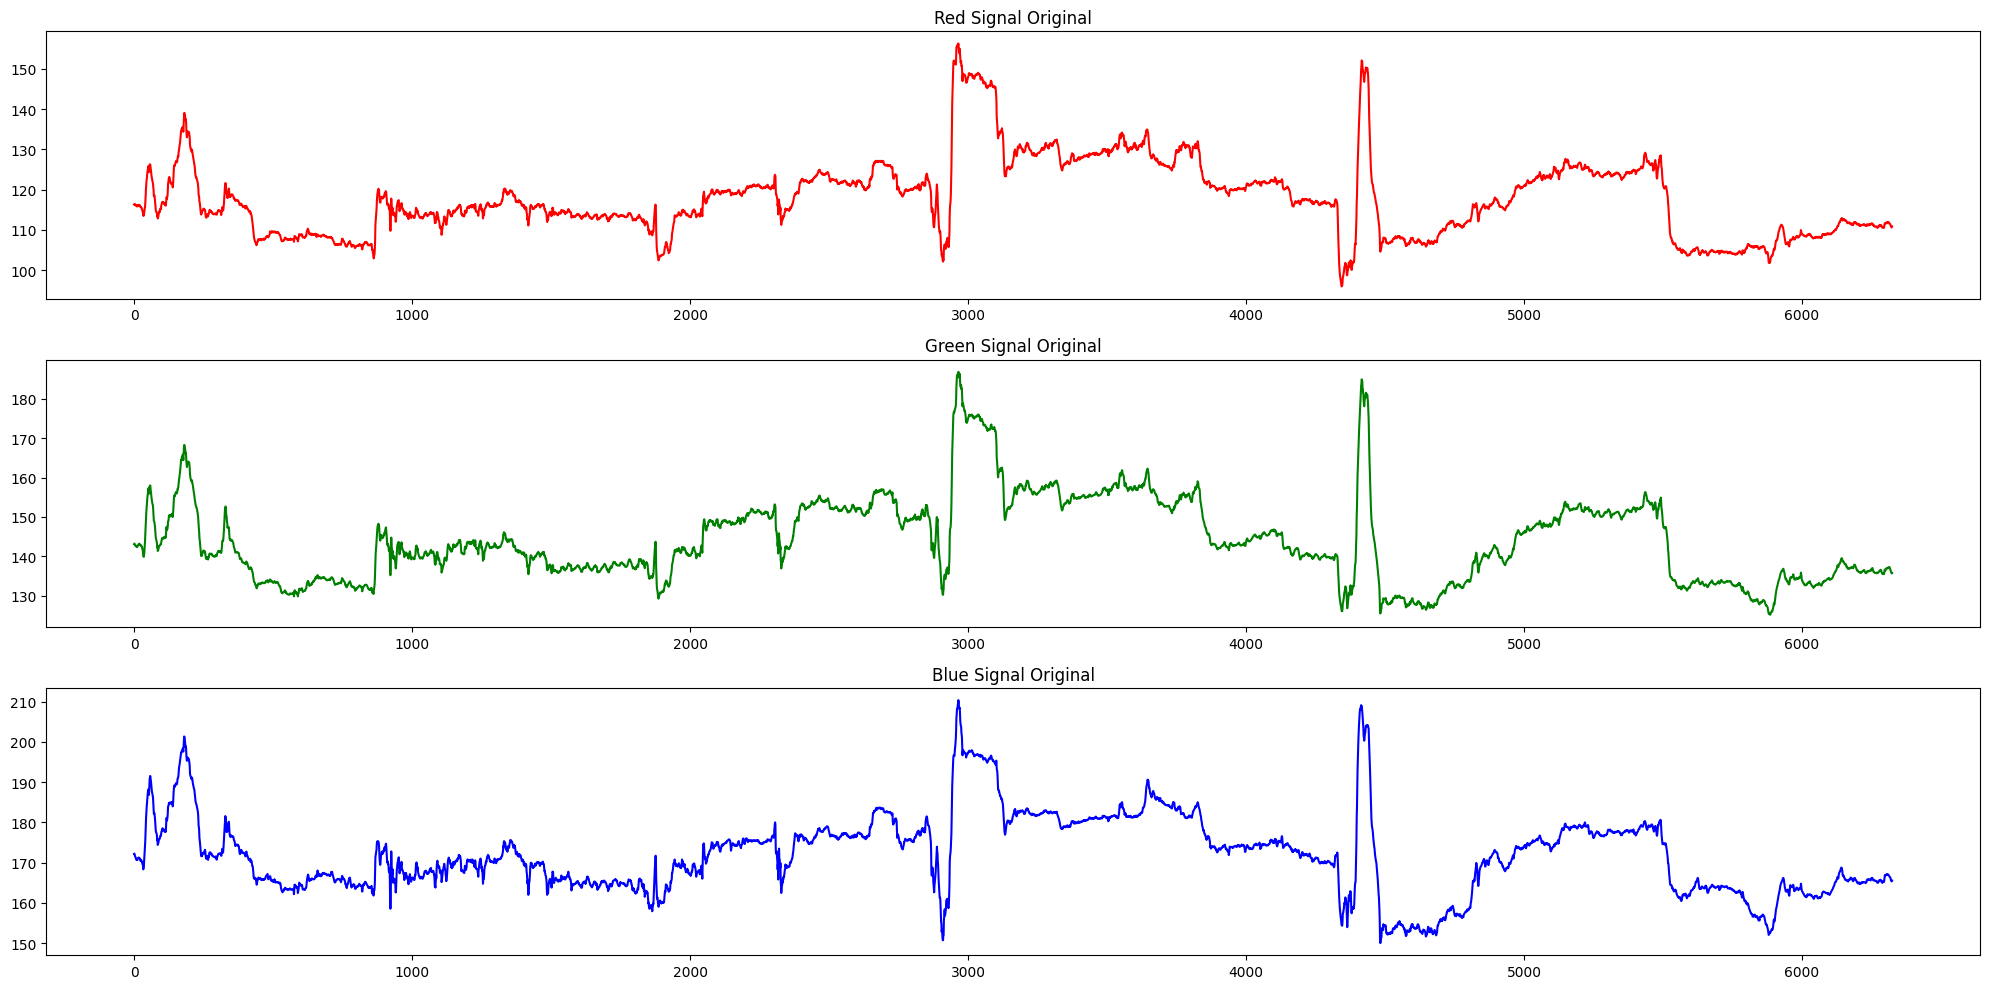

In [91]:
## Show the Signal Graph
ax, fig = plt.subplots(3, 1, figsize=(20, 10))
fig[0].plot(combined_r_signal, color='red')
fig[0].set_title('Red Signal Original')
fig[1].plot(combined_g_signal, color='green')
fig[1].set_title('Green Signal Original')
fig[2].plot(combined_b_signal, color='blue')
fig[2].set_title('Blue Signal Original')
plt.tight_layout()
plt.show()

<!-- ### Original RPPG Signal Method -->

In [92]:
def preprocess_signal(rppg_signal, fs):
    # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
    b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, rppg_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
    return smoothed

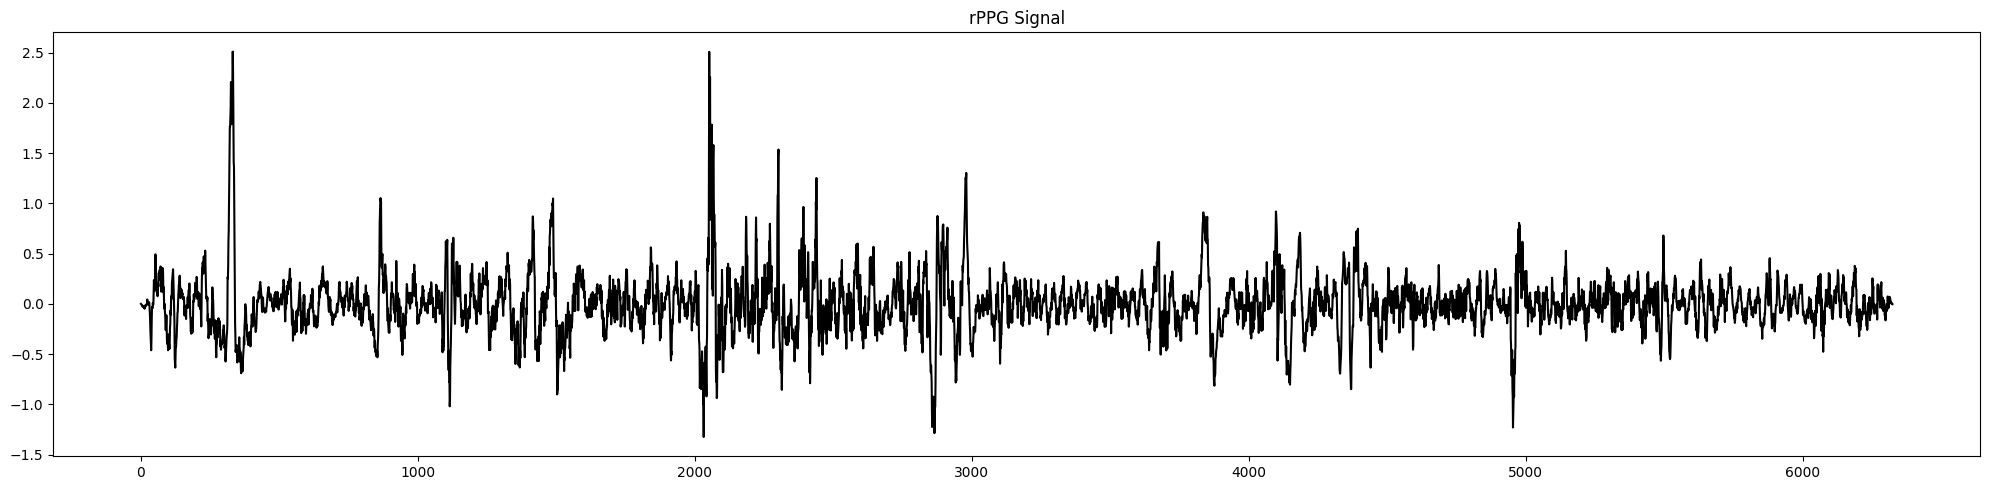

In [93]:
## Calculating the RPPG Signal
rgb_signals = np.array([combined_r_signal, combined_g_signal, combined_b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=35)
rppg_signal = rppg_signal.reshape(-1)

# Show the RPPG Signal
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

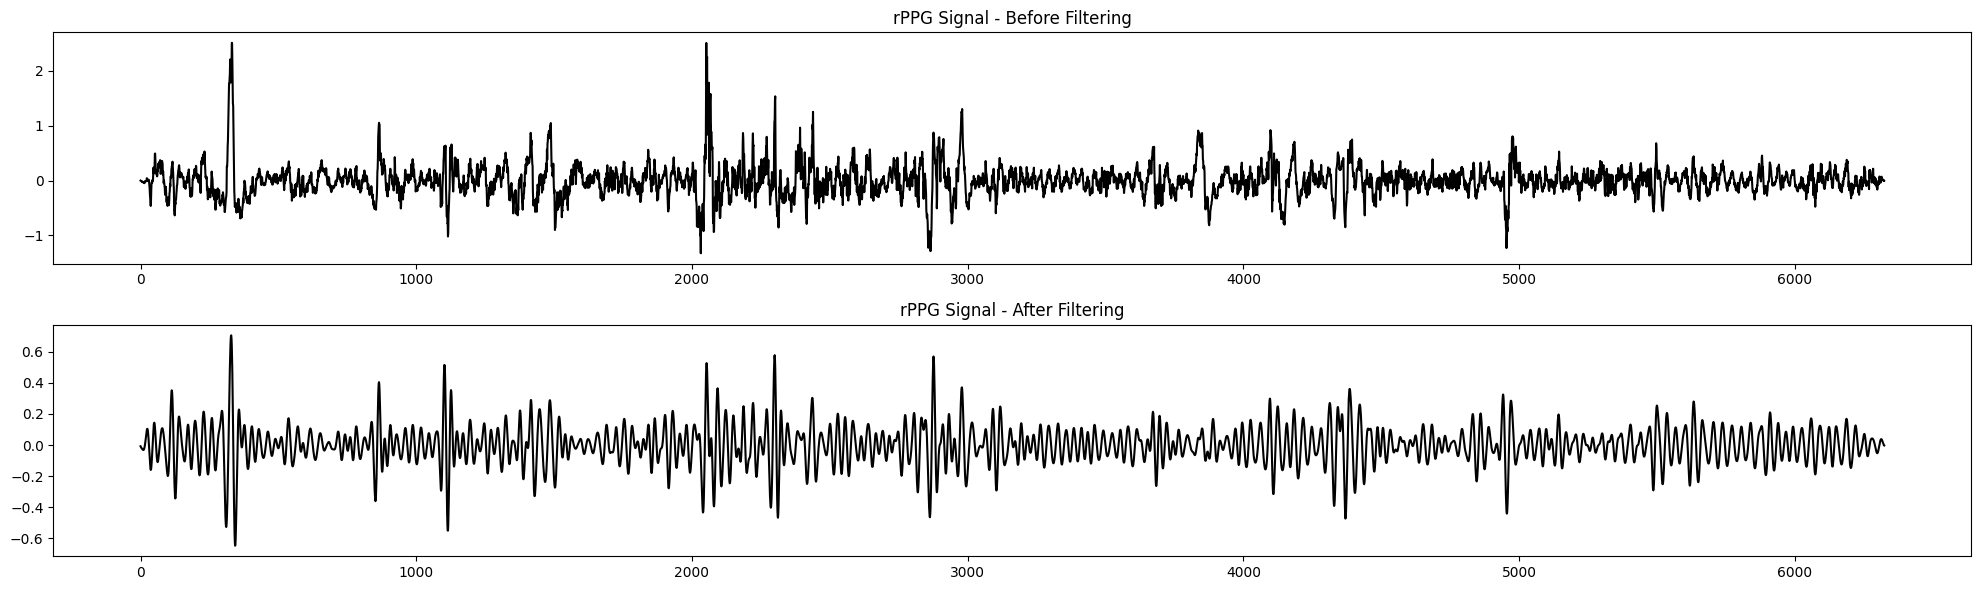

In [94]:
## Filter RPPG Signal
# fs = 35; lowcut = 0.8; highcut = 2.9; order = 3
# b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
# filtered_rppg = signal.filtfilt(b, a, rppg_signal)
filtered_rppg = preprocess_signal(rppg_signal, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(filtered_rppg, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

<!-- ### Normalize and Finds Peak as the Heart Rate (QRS Complex)

Peak detection sensitivity: Your prominence=0.5 threshold might be too sensitive for the rPPG signal, detecting minor peaks that aren't true heartbeats. This explains why rPPG heart rate is consistently higher. -->

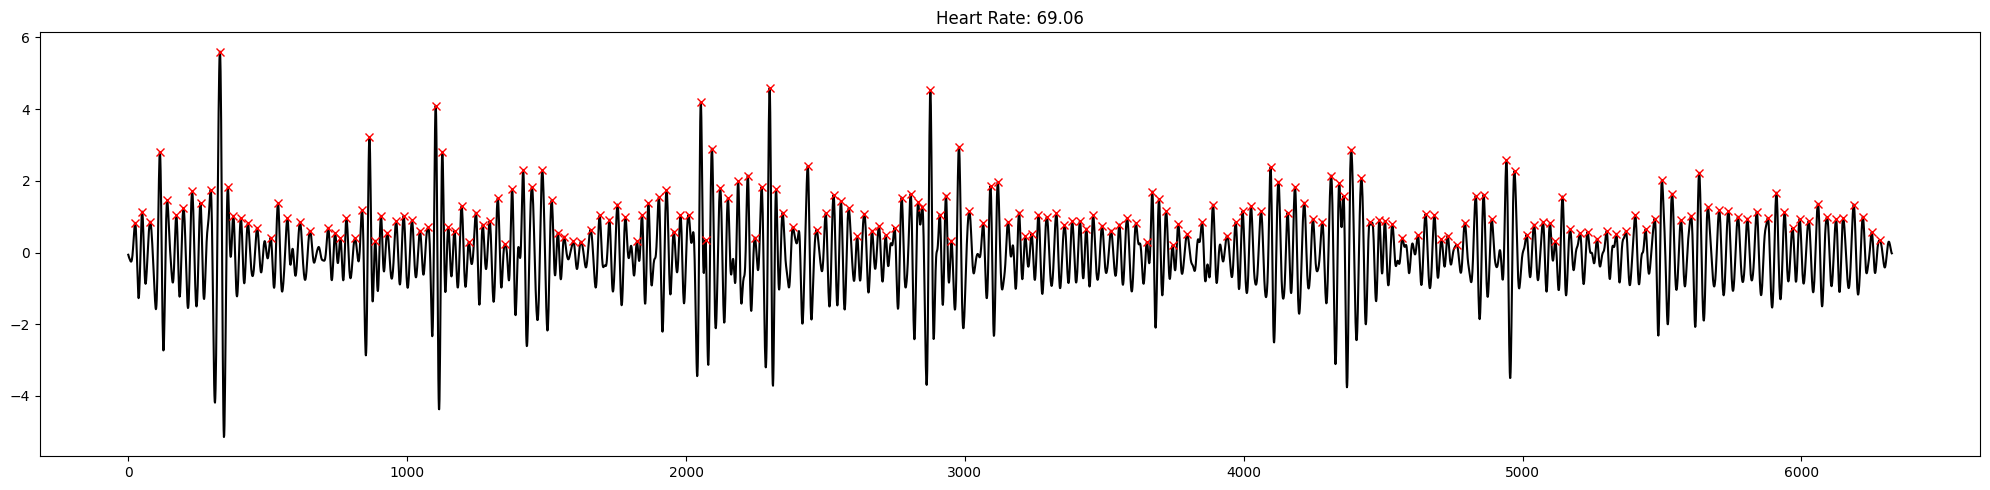

In [95]:
## Normalize the RPPG Signal
filtered_rppg = (filtered_rppg - np.mean(filtered_rppg)) / np.std(filtered_rppg)

## Finds Peak Signal
# peaks_rppg, _ = signal.find_peaks(
#     x=filtered_rppg,
#     prominence=0.8,  # Increase prominence threshold
#     distance=int(fs * 0.5)  # Minimum distance between peaks (0.5 seconds)
# )
peaks_rppg, _ = signal.find_peaks(
    x=filtered_rppg,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks_rppg) / (len(filtered_rppg) / fs)

plt.figure(figsize=(20, 5))
plt.plot(filtered_rppg, color='black')
plt.plot(peaks_rppg, filtered_rppg[peaks_rppg], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

In [96]:
# Calculate power in physiological band (0.8-2.0 Hz)
f, pxx = signal.welch(filtered_rppg, fs)
physio_power = np.sum(pxx[(f >= 0.8) & (f <= 2.0)])
total_power = np.sum(pxx)
signal_quality = physio_power / total_power

print(signal_quality)


0.9468152716100745


<!-- --- 

## Working on Ground Truth Signal


The ground truth basically has been downsample to have 35 Hz -->

In [97]:
# ## Take the sample of the first 30 seconds with 35 frame rate of the ground truth
# downsampled_ground_truth = downsampled_ground_truth[:interval_duration*fs]

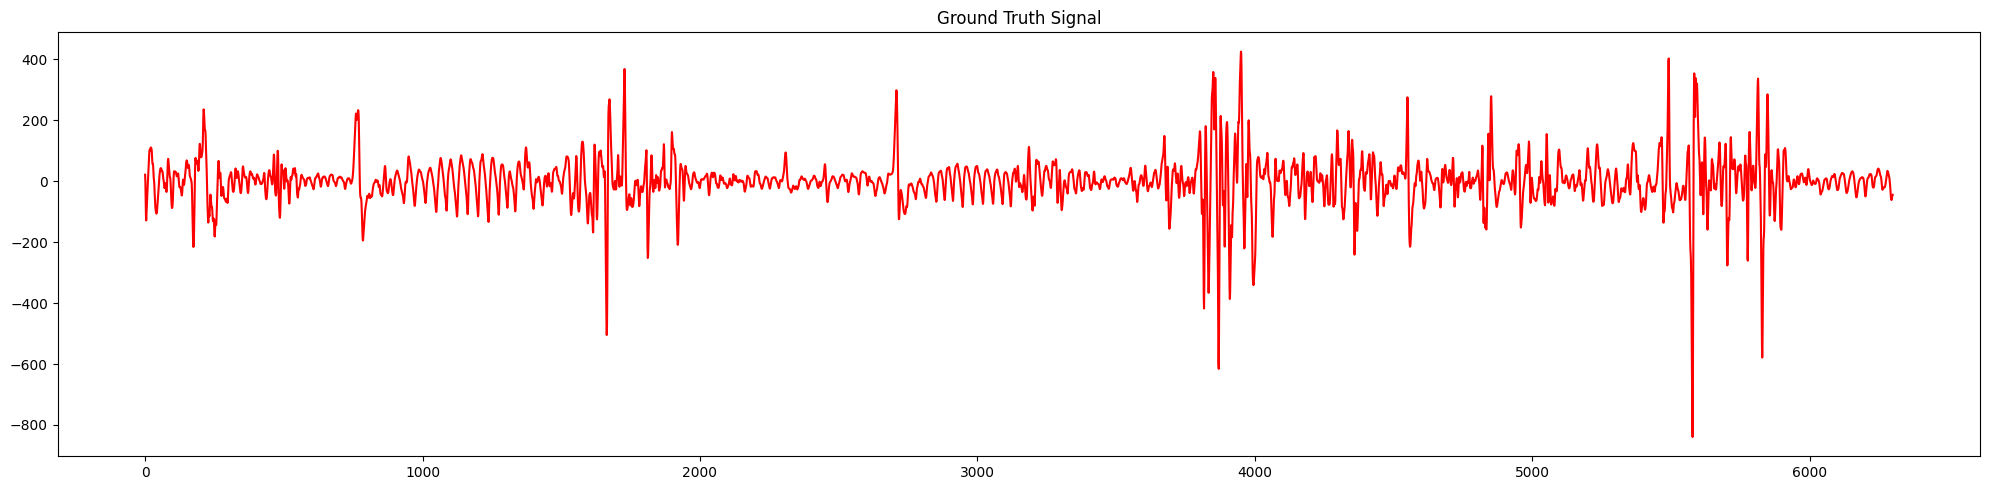

In [98]:
## Plot the Ground Truth
plt.figure(figsize=(20, 5)) 
plt.plot(downsampled_ground_truth, color='red')
plt.title('Ground Truth Signal')
plt.tight_layout()
plt.show()


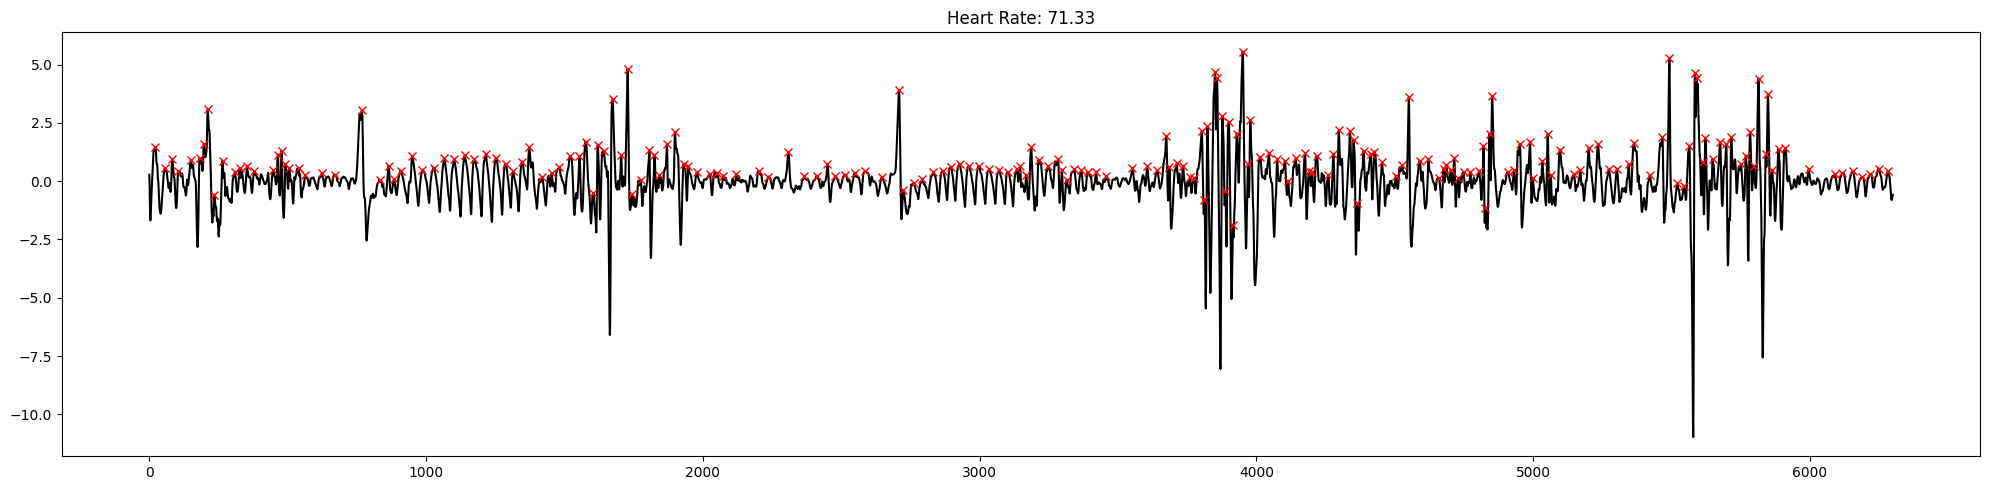

In [99]:
## Normalie the RPPG Signal
downsampled_ground_truth = (downsampled_ground_truth - np.mean(downsampled_ground_truth)) / np.std(downsampled_ground_truth)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=downsampled_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(downsampled_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(downsampled_ground_truth, color='black')
plt.plot(peaks, downsampled_ground_truth[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

In [100]:
# Calculate power in physiological band (0.8-2.0 Hz)
f, pxx = signal.welch(filtered_rppg, fs)
physio_power = np.sum(pxx[(f >= 0.8) & (f <= 2.0)])
total_power = np.sum(pxx)
signal_quality = physio_power / total_power

print(signal_quality)

0.9468152716100745


<!-- ### One Method, filter the Ground Truth -->

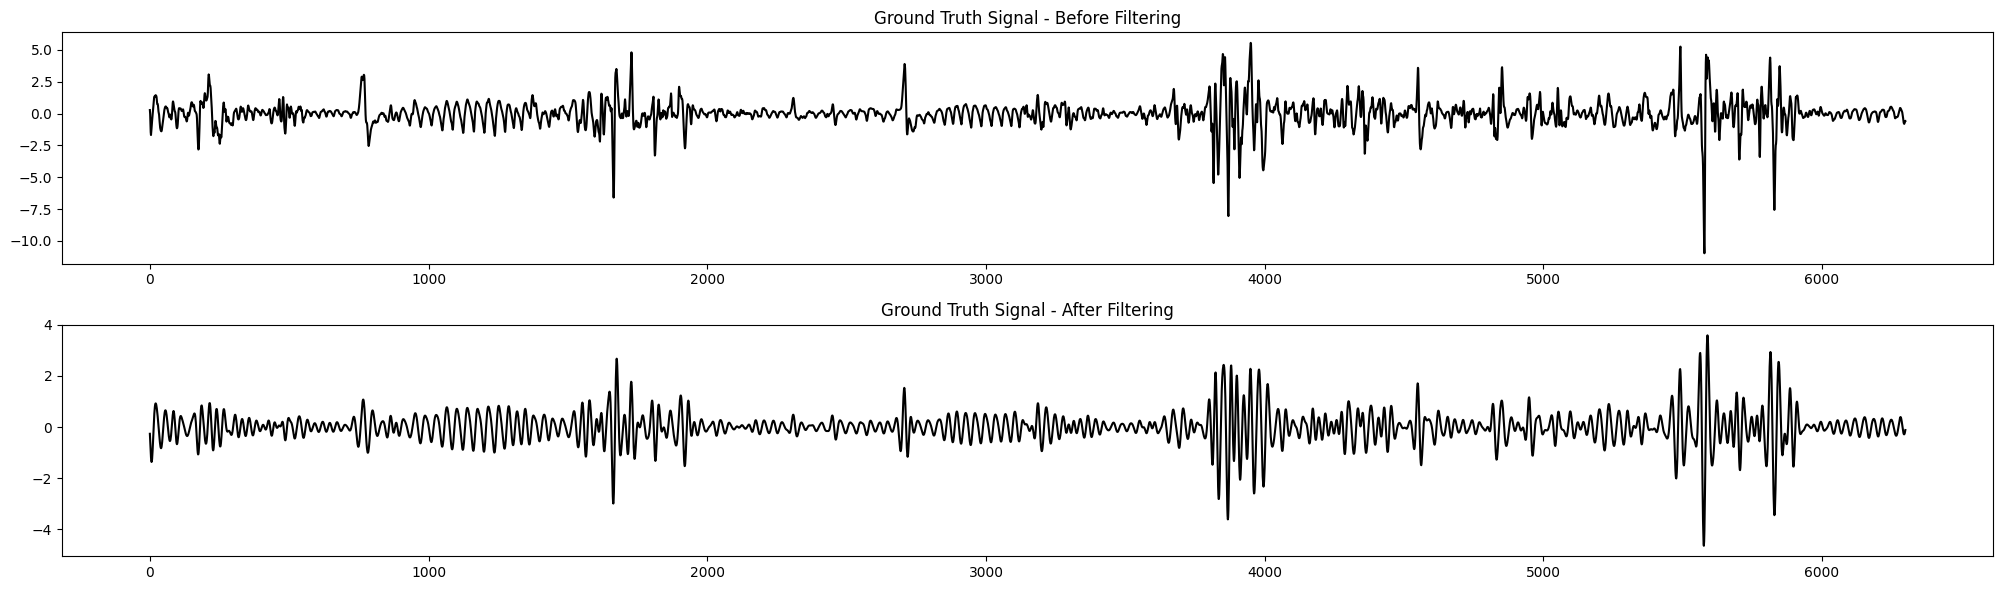

In [101]:
## Filter Original Length Signal
# fs = 35; lowcut = 0.8; highcut = 2.9; order = 3
# b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
# b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
# downsamped_filtered = signal.filtfilt(b, a, downsampled_ground_truth)

# # Additional lowpass to remove high-frequency noise
# b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
# downsampled_ground_truth = signal.filtfilt(b2, a2, downsamped_filtered)

# compressed_filtered_ground_truth = signal.filtfilt(b, a, downsampled_ground_truth)

compressed_filtered_ground_truth = preprocess_signal(downsampled_ground_truth, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(downsampled_ground_truth, color='black')
ax[0].set_title('Ground Truth Signal - Before Filtering')
ax[1].plot(compressed_filtered_ground_truth, color='black')
ax[1].set_title('Ground Truth Signal - After Filtering')
plt.tight_layout()
plt.show()

<!-- ### Normalize and Finds Peak as the Heart Rate (QRS Complex) -->

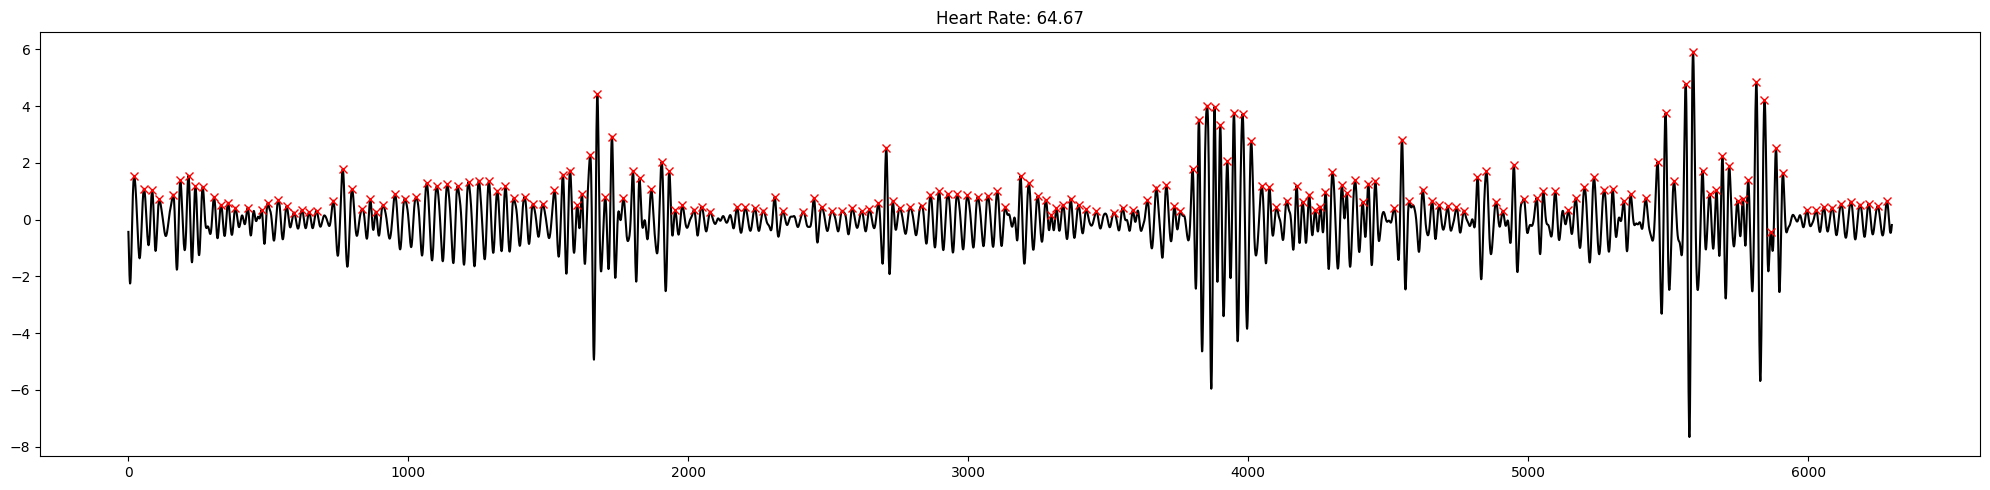

In [102]:
## Normalize the RPPG Signal
compressed_filtered_ground_truth = (compressed_filtered_ground_truth - np.mean(compressed_filtered_ground_truth)) / np.std(compressed_filtered_ground_truth)

## Finds Peak Signal
peaks_gt, _ = signal.find_peaks(
    x=compressed_filtered_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks_gt) / (len(compressed_filtered_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(compressed_filtered_ground_truth, color='black')
plt.plot(peaks_gt, compressed_filtered_ground_truth[peaks_gt], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

<!-- ---
Override Ground Truth and RPPG Signal are somehow not align, let's do the Frequency Analysis. -->

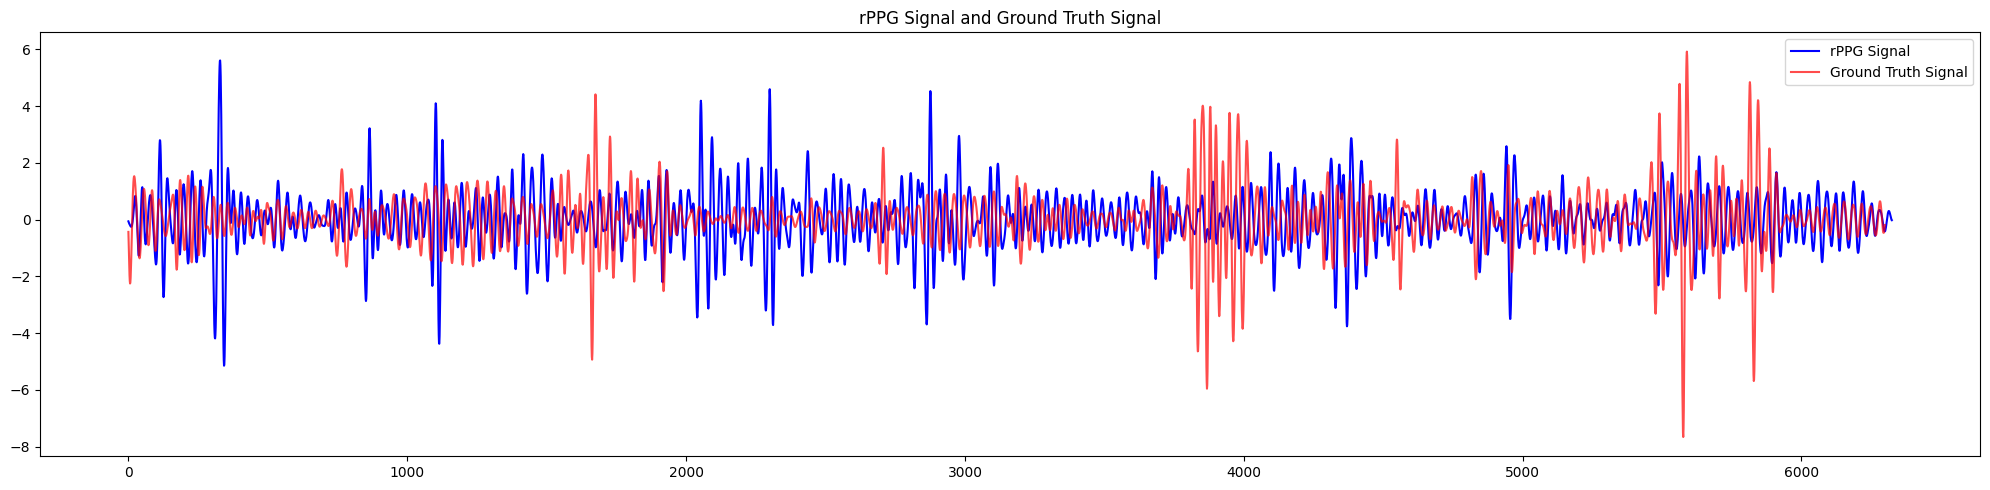

In [103]:
plt.figure(figsize=(20, 5))

# Plot rPPG signal
plt.plot(filtered_rppg, color='blue', label='rPPG Signal')

# Plot ground truth signal
plt.plot(compressed_filtered_ground_truth, color='red', alpha=0.7, label='Ground Truth Signal')

plt.title('rPPG Signal and Ground Truth Signal')
plt.legend()

plt.tight_layout()
plt.show()

<!-- ---
Frequency Analysis on Both Signal -->

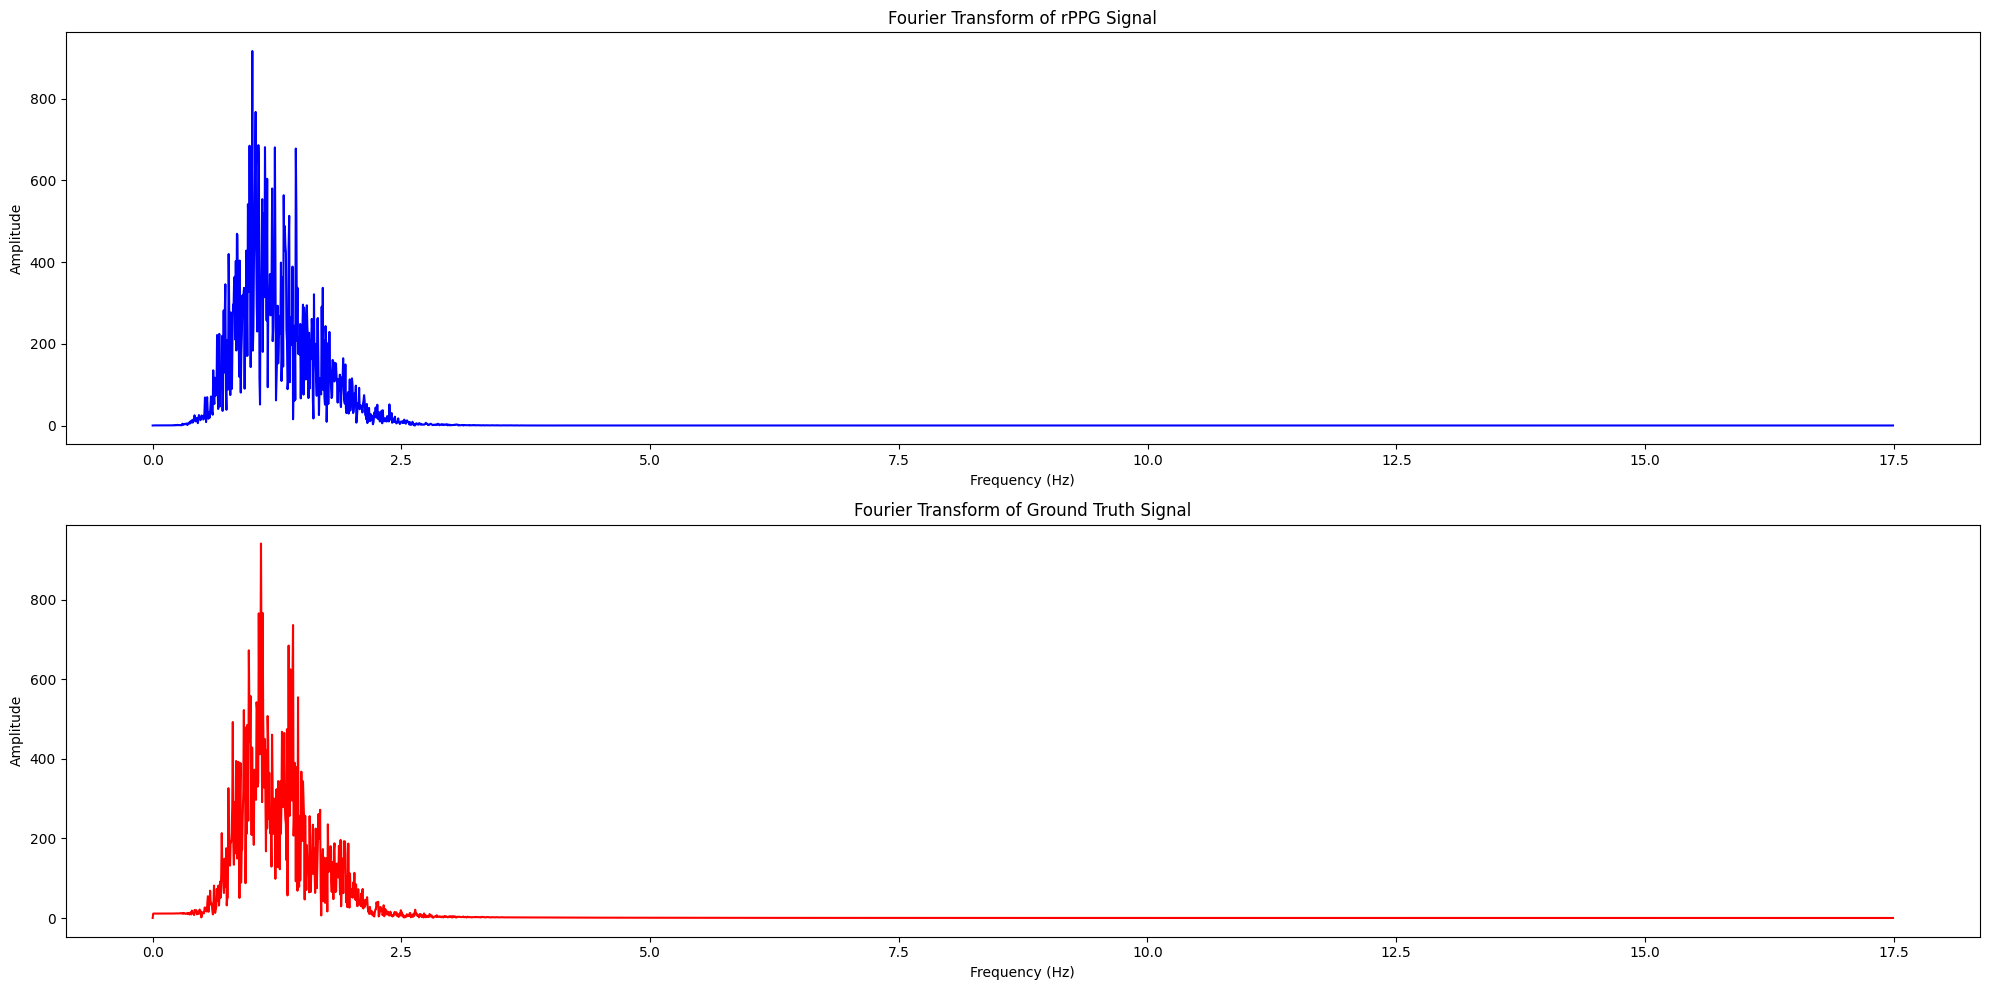

In [104]:
# Perform Fourier Transform on rPPG signal
rppg_freq = np.fft.fftfreq(len(filtered_rppg), d=1/fs)
rppg_fft = np.fft.fft(filtered_rppg)

# Perform Fourier Transform on ground truth signal
gt_freq = np.fft.fftfreq(len(compressed_filtered_ground_truth), d=1/fs)
gt_fft = np.fft.fft(compressed_filtered_ground_truth)

# Plot the Fourier Transforms
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Plot rPPG signal Fourier Transform
ax[0].plot(rppg_freq[:len(rppg_freq)//2], np.abs(rppg_fft)[:len(rppg_fft)//2], color='blue')
ax[0].set_title('Fourier Transform of rPPG Signal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')

# Plot ground truth signal Fourier Transform
ax[1].plot(gt_freq[:len(gt_freq)//2], np.abs(gt_fft)[:len(gt_fft)//2], color='red')
ax[1].set_title('Fourier Transform of Ground Truth Signal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

<!-- Calculating Dominant Freq -->

In [105]:
from scipy.fftpack import fft
import numpy as np

def dominant_frequency(signal, fs):
    freqs = np.fft.fftfreq(len(signal), d=1/fs)
    spectrum = np.abs(fft(signal))
    peak_freq = freqs[np.argmax(spectrum)]
    return peak_freq

rppg_freq = dominant_frequency(filtered_rppg, fs)
ground_truth_freq = dominant_frequency(compressed_filtered_ground_truth, fs)

print(f"rPPG Frequency: {rppg_freq} Hz")
print(f"Ground Truth Frequency: {ground_truth_freq} Hz")

rPPG Frequency: 1.0015810276679842 Hz
Ground Truth Frequency: 1.088888888888889 Hz


### Feature Extraction

Based on the article, it seems we can take some features on the RPPG signal such as the SD, RMSSD, and other stuff. and do Some classification on the interval of 30 sec or so?

MeanNN: 769.84 ms, SDNN: 146.45 ms, RMSSD: 192.51 ms, NN50: 29, pNN50: 0.81
LF: 0.00 ms^2, HF: 0.00 ms^2, LF/HF Ratio: nan


C:\Users\ACER\AppData\Local\Temp\ipykernel_11336\3717165199.py:23: RuntimeWarning: invalid value encountered in scalar divide
  lf_hf_ratio = lf / hf


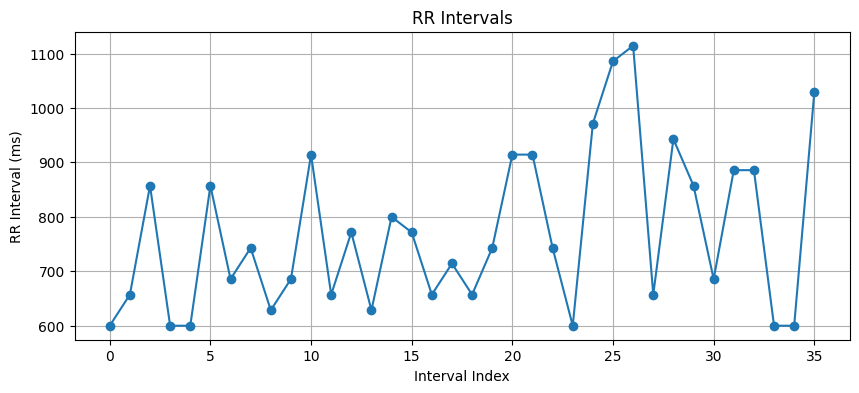

In [106]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Example rPPG signal (replace with your actual rPPG signal)
rppg_signal = np.random.randn(1000)  # Replace with actual rPPG signal
fs = 35  # Sampling frequency in Hz

# Function to calculate time-domain features
def time_domain_features(rr_intervals):
    mean_nn = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pnn50 = nn50 / len(rr_intervals)
    return mean_nn, sdnn, rmssd, nn50, pnn50

# Function to calculate frequency-domain features
def frequency_domain_features(rr_intervals, fs):
    f, pxx = signal.welch(rr_intervals, fs=fs, nperseg=len(rr_intervals))
    lf = np.trapz(pxx[(f >= 0.04) & (f < 0.15)])
    hf = np.trapz(pxx[(f >= 0.15) & (f < 0.4)])
    lf_hf_ratio = lf / hf
    return lf, hf, lf_hf_ratio

# Function to calculate RR intervals from rPPG signal
def calculate_rr_intervals(rppg_signal, fs):
    peaks, _ = signal.find_peaks(rppg_signal, distance=fs*0.6)  # Adjust distance based on expected heart rate
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    return rr_intervals

# Calculate RR intervals
rr_intervals = calculate_rr_intervals(rppg_signal, fs)

# Calculate time-domain features
mean_nn, sdnn, rmssd, nn50, pnn50 = time_domain_features(rr_intervals)
print(f"MeanNN: {mean_nn:.2f} ms, SDNN: {sdnn:.2f} ms, RMSSD: {rmssd:.2f} ms, NN50: {nn50}, pNN50: {pnn50:.2f}")

# Calculate frequency-domain features
lf, hf, lf_hf_ratio = frequency_domain_features(rr_intervals, fs)
print(f"LF: {lf:.2f} ms^2, HF: {hf:.2f} ms^2, LF/HF Ratio: {lf_hf_ratio:.2f}")

# Plot RR intervals
plt.figure(figsize=(10, 4))
plt.plot(rr_intervals, marker='o')
plt.title('RR Intervals')
plt.xlabel('Interval Index')
plt.ylabel('RR Interval (ms)')
plt.grid()
plt.show()